# Amazon Books Bestsellers

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
df = pd.read_csv('bestsellers with categories.csv')

In [38]:
df.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


## Data Cleaning and Exploration

In [39]:
# check for nan values
df.isnull().sum()

Name           0
Author         0
User Rating    0
Reviews        0
Price          0
Year           0
Genre          0
dtype: int64

In [40]:
# summary statistics
df.describe()

,User Rating,Reviews,Price,Year
count,550.000000,550.000000,550.000000,550.000000
mean,4.618364,11953.281818,13.100000,2014.000000
std,0.226980,11731.132017,10.842262,3.165156
min,3.300000,37.000000,0.000000,2009.000000
25%,4.500000,4058.000000,7.000000,2011.000000
50%,4.700000,8580.000000,11.000000,2014.000000
75%,4.800000,17253.250000,16.000000,2017.000000
max,4.900000,87841.000000,105.000000,2019.000000


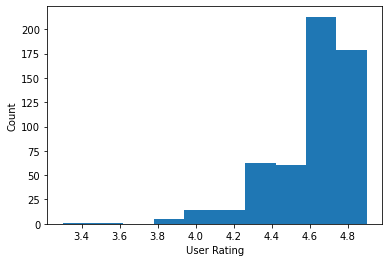

In [41]:
# histogram of user ratings
plt.hist(df['User Rating'], bins=10)
plt.xlabel('User Rating')
plt.ylabel('Count')
plt.show()

/Users/ericluong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


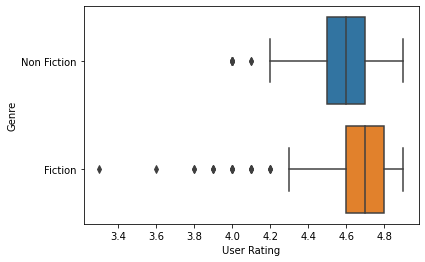

In [42]:
# boxplot of user ratings by genre
sns.boxplot(df['User Rating'], df['Genre'])
plt.show()

/Users/ericluong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


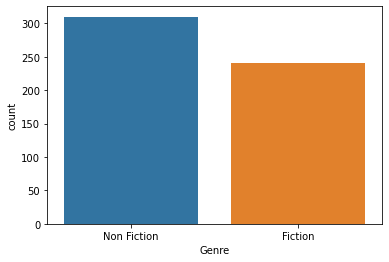

In [43]:
# bar chart for genre distribution
sns.countplot(df['Genre'])
plt.show()

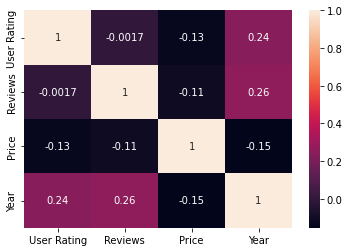

In [44]:
# correlation matrix for numeric variables
sns.heatmap(df.corr(), annot=True)
plt.show()

<AxesSubplot:xlabel='Year', ylabel='Reviews'>

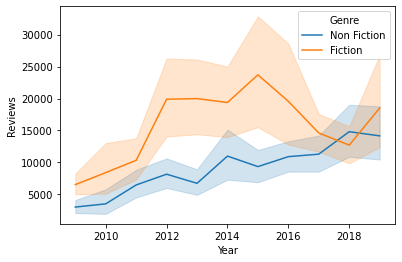

In [45]:
# time series analysis of book reviews over time by genre
sns.lineplot(x='Year', y='Reviews', hue='Genre', data=df)

## Regression Analysis

In [46]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [51]:
# convert Year to datetime
df['Year'] = pd.to_datetime(df['Year'], format='%Y').dt.year

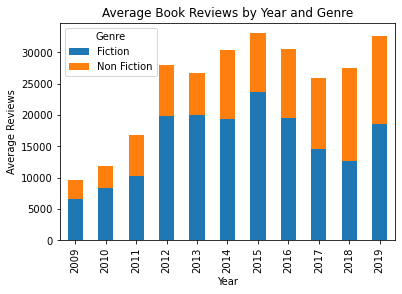

In [55]:
# Group the data by year and genre
df_grouped = df.groupby(['Year', 'Genre'])['Reviews'].mean().reset_index()

# Pivot the data to create a table with years as rows and genres as columns
df_pivot = df_grouped.pivot(index='Year', columns='Genre', values='Reviews')

# Plot the grouped bar plot
df_pivot.plot(kind='bar', stacked=True)
plt.title('Average Book Reviews by Year and Genre')
plt.xlabel('Year')
plt.ylabel('Average Reviews')
plt.show()


## NLP Book Titles to Reviews

In [62]:
import pandas as pd

# Create a new dataframe with title and reviews columns
df_title = df[['Name', 'Reviews']]

In [65]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Download the NLTK stop words and initialize the stemmer
nltk.download('stopwords')
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# Preprocess the book titles by removing stop words and stemming the remaining words
def preprocess_text(text):
    words = nltk.word_tokenize(text.lower())
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

df_title['Title Processed'] = df_title['Name'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ericluong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/42/0ktpxb410cg701991z265xdw0000gn/T/ipykernel_90501/1770653854.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_title['Title Processed'] = df_title['Name'].apply(preprocess_text)


In [66]:
from sklearn.feature_extraction.text import CountVectorizer

# Use CountVectorizer to convert the preprocessed text into a bag-of-words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_title['Title Processed'])


In [67]:
from sklearn.linear_model import LinearRegression

# Train a linear regression model on the bag-of-words features and the number of reviews
model = LinearRegression()
model.fit(X, df_title['Reviews'])


LinearRegression()

             Coefficient
becom       47944.318566
sing        37326.159578
crawdad     37326.159578
nightingal  35248.528095
train       34923.690808
girl        31333.629520
martian     26270.319648
orphan      26182.373550
freed       24701.996579
breath      23676.999257


/Users/ericluong/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


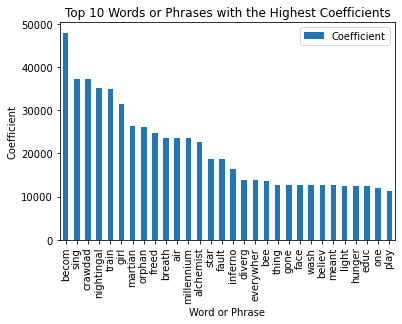

In [73]:
import matplotlib.pyplot as plt

# Get the coefficients of the trained model and map them back to the vocabulary
coefficients = pd.DataFrame(model.coef_, index=vectorizer.get_feature_names(), columns=['Coefficient'])

# Sort the coefficients by magnitude
coefficients = coefficients.abs().sort_values(by='Coefficient', ascending=False)

# Print the top 10 words or phrases with the highest coefficients
print(coefficients.head(10))

# Plot the top 10 words or phrases with the highest coefficients
coefficients.head(30).plot(kind='bar')
plt.title('Top 10 Words or Phrases with the Highest Coefficients')
plt.xlabel('Word or Phrase')
plt.ylabel('Coefficient')
plt.show()



## K-Means of Amazon Bestsellers

In [74]:
X = df[['User Rating', 'Reviews', 'Price']]

In [75]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [84]:
from sklearn.cluster import KMeans

k = 3 # number of clusters to create
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=3, random_state=42)

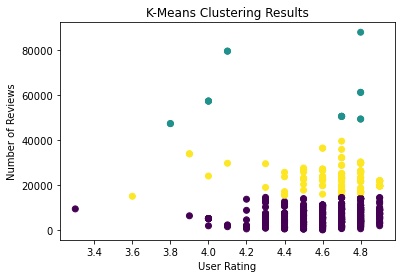

In [85]:
import matplotlib.pyplot as plt

plt.scatter(X['User Rating'], X['Reviews'], c=kmeans.labels_, cmap='viridis')
plt.xlabel('User Rating')
plt.ylabel('Number of Reviews')
plt.title('K-Means Clustering Results')
plt.show()


In [92]:
# Convert cluster_centers to a dataframe
centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

# Rename columns
centers_df = centers_df.rename(columns={'User Rating': 'Mean User Rating', 'Reviews': 'Mean Reviews', 'Price': 'Mean Price'})

# Add a column with the counts of each cluster
counts = pd.Series(kmeans.labels_).value_counts().sort_index()
centers_df['Count'] = counts.values

# Print the cluster centers dataframe
print(centers_df)



   Mean User Rating  Mean Reviews  Mean Price  Count
0          4.604798   6235.063131   14.020202    396
1          4.412500  58490.375000   11.687500     16
2          4.681159  22966.478261   10.623188    138


In [87]:
# Filter the dataframe to include only books in cluster 1
cluster_1 = df[kmeans.labels_ == 1]

# Extract the titles, authors, and genres of the books in cluster 1
titles = cluster_1['Name']
authors = cluster_1['Author']
genres = cluster_1['Genre']

In [95]:
titles

32                                              Becoming
33                                              Becoming
106    Fifty Shades of Grey: Book One of the Fifty Sh...
107    Fifty Shades of Grey: Book One of the Fifty Sh...
135                                            Gone Girl
136                                            Gone Girl
137                                            Gone Girl
365                               The Fault in Our Stars
366                               The Fault in Our Stars
367                               The Fault in Our Stars
368                               The Fault in Our Stars
382                                The Girl on the Train
383                                The Girl on the Train
437                             The Nightingale: A Novel
438                             The Nightingale: A Novel
534                              Where the Crawdads Sing
Name: Name, dtype: object

In [104]:
# Predict the cluster labels for each book
labels = kmeans.predict(X)

# Filter the dataframe to include only books from cluster 1
cluster_1 = df.loc[labels == 1, ['Name', 'Author', 'Genre']]
cluster_2 = df.loc[labels == 2, ['Name', 'Author', 'Genre']]
cluster_3 = df.loc[labels == 0, ['Name', 'Author', 'Genre']]

In [97]:
cluster_1

,Name,Author,Genre
32,Becoming,Michelle Obama,Non Fiction
33,Becoming,Michelle Obama,Non Fiction
106,Fifty Shades of Grey: Book One of the Fifty Sh...,E L James,Fiction
107,Fifty Shades of Grey: Book One of the Fifty Sh...,E L James,Fiction
135,Gone Girl,Gillian Flynn,Fiction
136,Gone Girl,Gillian Flynn,Fiction
137,Gone Girl,Gillian Flynn,Fiction
365,The Fault in Our Stars,John Green,Fiction
366,The Fault in Our Stars,John Green,Fiction
367,The Fault in Our Stars,John Green,Fiction


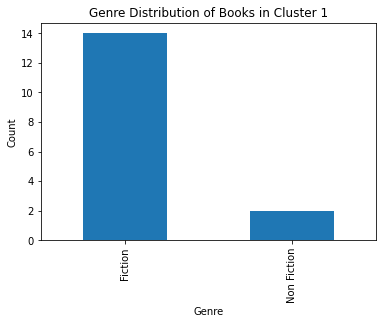

In [102]:
plot = cluster_1['Genre'].value_counts().plot(kind='bar', title='Genre Distribution of Books in Cluster 1')
plot.set_xlabel('Genre')
plot.set_ylabel('Count')
plt.show()

In [105]:
cluster_2

,Name,Author,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,Non Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,Non Fiction
3,1984 (Signet Classics),George Orwell,Fiction
6,A Game of Thrones / A Clash of Kings / A Storm...,George R. R. Martin,Fiction
7,A Gentleman in Moscow: A Novel,Amor Towles,Fiction
...,...,...,...
540,Wonder,R. J. Palacio,Fiction
541,Wonder,R. J. Palacio,Fiction
542,Wonder,R. J. Palacio,Fiction
543,Wonder,R. J. Palacio,Fiction


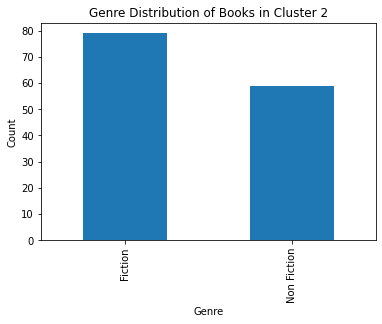

In [103]:
plot = cluster_2['Genre'].value_counts().plot(kind='bar', title='Genre Distribution of Books in Cluster 2')
plot.set_xlabel('Genre')
plot.set_ylabel('Count')
plt.show()

In [106]:
cluster_3

,Name,Author,Genre
1,11/22/63: A Novel,Stephen King,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,Non Fiction
5,A Dance with Dragons (A Song of Ice and Fire),George R. R. Martin,Fiction
8,"A Higher Loyalty: Truth, Lies, and Leadership",James Comey,Non Fiction
11,A Patriot's History of the United States: From...,Larry Schweikart,Non Fiction
...,...,...,...
545,Wrecking Ball (Diary of a Wimpy Kid Book 14),Jeff Kinney,Fiction
546,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,Non Fiction
547,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,Non Fiction
548,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,Non Fiction


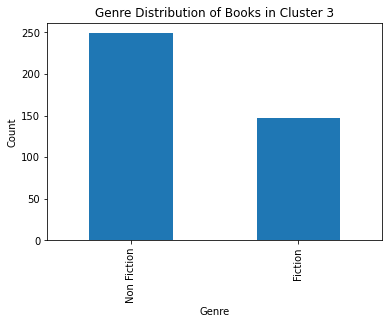

In [107]:
plot = cluster_3['Genre'].value_counts().plot(kind='bar', title='Genre Distribution of Books in Cluster 3')
plot.set_xlabel('Genre')
plot.set_ylabel('Count')
plt.show()

Cluster 0 has an average user rating of 4.60, an average number of reviews of 6,235, and an average price of $14.02. This may indicate that books in this cluster are generally well-liked by readers, but are not necessarily bestsellers or high-priced books. More of niche books.

On the other hand, Cluster 1 has an average user rating of 4.41, an average number of reviews of 58,490, and an average price of $11.69. This may indicate that books in this cluster are very popular and have a large number of reviews, but are not necessarily highly rated or high-priced.

Finally, Cluster 2 has an average user rating of 4.68, an average number of reviews of 22,966, and an average price of $10.62. This may indicate that books in this cluster are both well-liked by readers and popular, and are also priced affordably. This cluster may represent books that are both critically and commercially successful.